First things first: I have some data analysis background from my research career in particle physics, but I am far from being an machine learning expert. So please bear with me and I am happy to receive any kind of feedback.

Since the training data set (and possibly the test data as well) contain missing data, I wanted to have a closer look at this issue. I have seen that other participants propose to fill those NaNs with the mean or median for the respective column. Here I am not (yet) that much interested in filling the blanks but I rather want to know whether we can learn something more about the data when looking missing values.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
with pd.HDFStore('../data/train.h5') as train:
    df = train.get('train')

Let's see how much data we've got:

In [4]:
print(df.shape)

(1710756, 111)


That's quite a few column. So let's see which columns have missing values and how much data is actually missing.

<Container object of 111 artists>

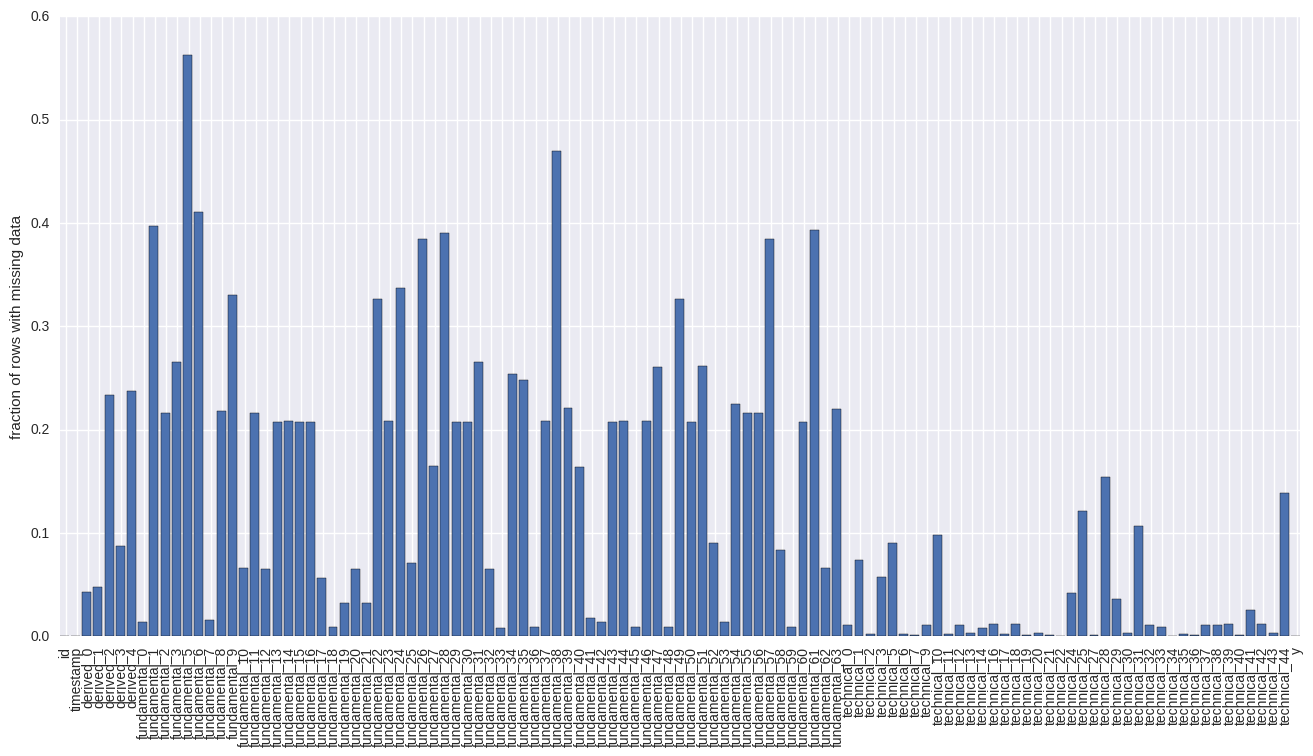

In [5]:
null_counts = df.isnull().sum()/len(df)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

Uh, that is quite a lot of missing data. Almost all feature columns contain missing values and the fraction of rows with missing data can be substantial.
Ok, let's try to become a bit more quantitative. We can calculate for every ID (= financial asset) and feature column the following information:
* number of missing values
* relative fraction of missing values (= number missing values / timespan for which this ID is present)
* number of continuous time spans with missing values (to see whether data is only missing for a certain period of time or whether missing values occur irregularly over the total time span an asset is held)

In [6]:
# drop non-feature columns
feature_columns = df.columns.drop(['id','timestamp','y'])
# create multi-index with (count, fraction, number of NaN sequences) per feature column
iterables = [feature_columns,['count','fraction','seq']]
index = pd.MultiIndex.from_product(iterables,names=['feature','stat'])
# use list of IDs as index (only sorted for easier navigation)
ids = df.id.unique()
ids.sort()
# create empty data frame
nan_df = pd.DataFrame(data=None,index=ids,columns=index)

The calculation should be straightforward except maybe for the number of connected time ranges with missing data. Here the idea is the following:
* get the row indices for NaNs in a feature column
* enumerate those indices
* for a continuous time period of NaNs `enumeration index - row index` should be constant
* use [groupby from itertools](https://docs.python.org/3/library/itertools.html#itertools.groupby) to get the list of continous time spans of NaNs

In [7]:
from itertools import groupby
# iterate over all asset ID
for name,group in df.groupby('id'):
    # for every feature column
    for c in feature_columns:
        # total number of rows with missing data
        nan_count = group[c].isnull().sum()
        # time span this ID was present
        timespan = len(group[c])
        # row indices for missing data
        nan_indices = pd.isnull(group[c]).nonzero()[0]
        # get number of joint time spans of missing values
        nseq = len(list(groupby(enumerate(nan_indices),lambda x:x[0]-x[1])))
        nan_df.loc[name][c,'count'] = nan_count
        nan_df.loc[name][c,'fraction'] = nan_count * 1.0/timespan
        nan_df.loc[name][c,'seq'] = nseq

Let's have a quick look at the resulting data frame.

In [7]:
nan_df.head(20)

feature derived_0                 derived_1                 derived_2  \
stat        count    fraction seq     count    fraction seq     count   
0               3   0.0018226   1         3   0.0018226   1         3   
6               4  0.00549451   1         4  0.00549451   1         4   
7               3  0.00194426   1         3  0.00194426   1         3   
10              0           0   0         0           0   0         0   
11              0           0   0         0           0   0         0   
12              0           0   0         0           0   0         0   
13              3  0.00194426   1         3  0.00194426   1      1543   
14              4   0.0183486   1         4   0.0183486   1       218   
15              4  0.00298507   1         4  0.00298507   1      1340   
16              3   0.0017192   1         3   0.0017192   1         3   
17            275    0.353017   1       344    0.441592   1         4   
18              4   0.0183486   1         4   0.0183486   1         4   
19              3  0.00361882   1         3  0.00361882   1         3   
20              3   0.0018226   1         3   0.0018226   1         3   
22              4  0.00277393   1         4  0.00277393   1         4   
23              4   0.0183486   1         4   0.0183486   1         4   
24              3  0.00321888   1         3  0.00321888   1         3   
25             87   0.0479868   1        53   0.0292333   1         1   
26              0           0   0         0           0   0         0   
27              0           0   0         0           0   0         0   

feature                  derived_3 ... technical_41 technical_42              \
stat        fraction seq     count ...          seq        count    fraction   
0          0.0018226   1         3 ...            1            3   0.0018226   
6         0.00549451   1         4 ...            1            4  0.00549451   
7         0.00194426   1         3 ...            1            3  0.00194426   
10                 0   0         0 ...            1           21    0.181034   
11                 0   0         0 ...            1           21    0.011583   
12                 0   0         0 ...            1           21    0.011583   
13                 1   1         3 ...            1            3  0.00194426   
14                 1   1         4 ...            1            4   0.0183486   
15                 1   1         4 ...            1            4  0.00298507   
16         0.0017192   1         3 ...            1            3   0.0017192   
17        0.00513479   1       598 ...            1            4  0.00513479   
18         0.0183486   1         4 ...            1            4   0.0183486   
19        0.00361882   1         3 ...            1            3  0.00361882   
20         0.0018226   1         3 ...            1            3   0.0018226   
22        0.00277393   1         4 ...            1            4  0.00277393   
23         0.0183486   1         4 ...            1            4   0.0183486   
24        0.00321888   1         3 ...            1            3  0.00321888   
25       0.000551572   1        71 ...            1           21    0.011583   
26                 0   0         0 ...            1           21    0.011583   
27                 0   0         0 ...            1           21    0.132075   

feature     technical_43                 technical_44                 
stat    seq        count    fraction seq        count   fraction seq  
0         1            3   0.0018226   1          182   0.110571   1  
6         1            4  0.00549451   1          184   0.252747   1  
7         1            3  0.00194426   1          182   0.117952   1  
10        1            0           0   0          116          1   1  
11        1            0           0   0          165  0.0910094   1  
12        1            0           0   0          165  0.0910094   1  
13        1            3  0.00194426   1          182   0.117952

Ok, this looks reasonable at the first glance. In order to get a better feeling, let's have a look at the mean fraction of missing data per feature column and its standard deviation (where mean and std are calculated over the sample of all IDs in the training data).

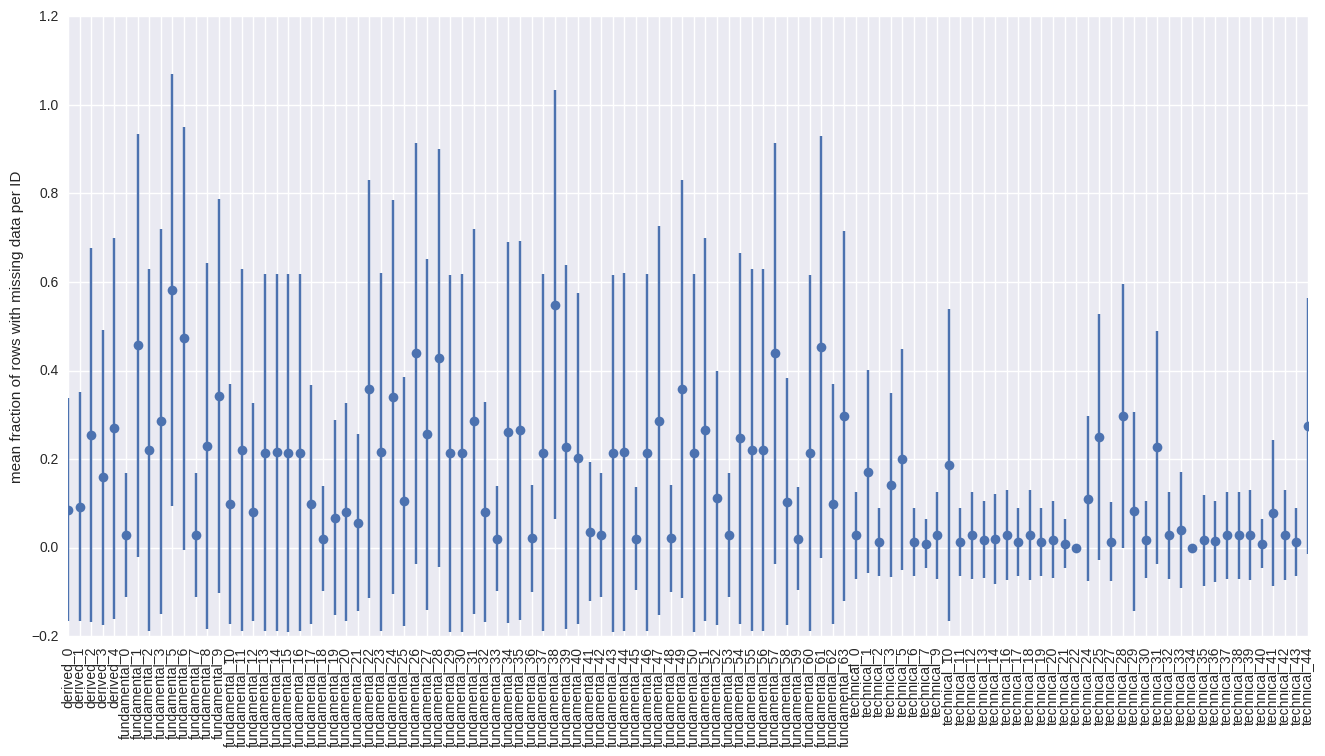

In [8]:
fractions = nan_df.xs('fraction',level='stat',axis=1)
fraction_mean = fractions.mean()
fraction_std = fractions.std()
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(fraction_mean)),fraction_mean.index,rotation='vertical')
plt.errorbar(np.arange(len(fraction_mean)),fraction_mean,yerr=fraction_std,fmt='o')
plt.ylabel('mean fraction of rows with missing data per ID');

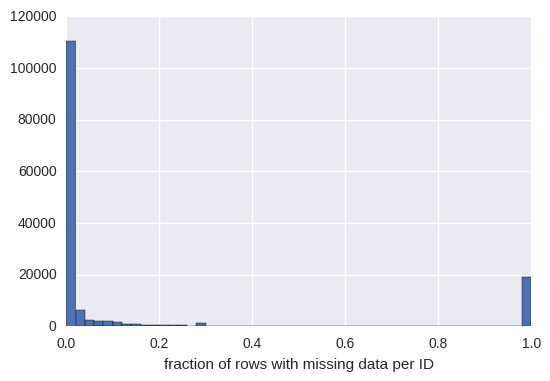

In [9]:
plt.hist(fractions.values.flatten(),bins=50)
plt.xlabel('fraction of rows with missing data per ID');

This looks interesting. For a given ID and feature column either <30% of the data is missing or all of it. The large gap in between renders the mean values a bit misleading. But what it is interesting to me is the fact that the standard deviation varies quite a bit. For fundamental and derived data the variations among different IDs seem to be (in general) larger than for the technical feature columns. One reason could be that fundamental data could be missing for fixed number of time stamps (e.g. the first N occurences) which would lead to large variations since time spans for which different IDs are present vary quite a bit as other participants already revealed. In order to test this, we can make the same plot for the absolute number of missing values per feature column.

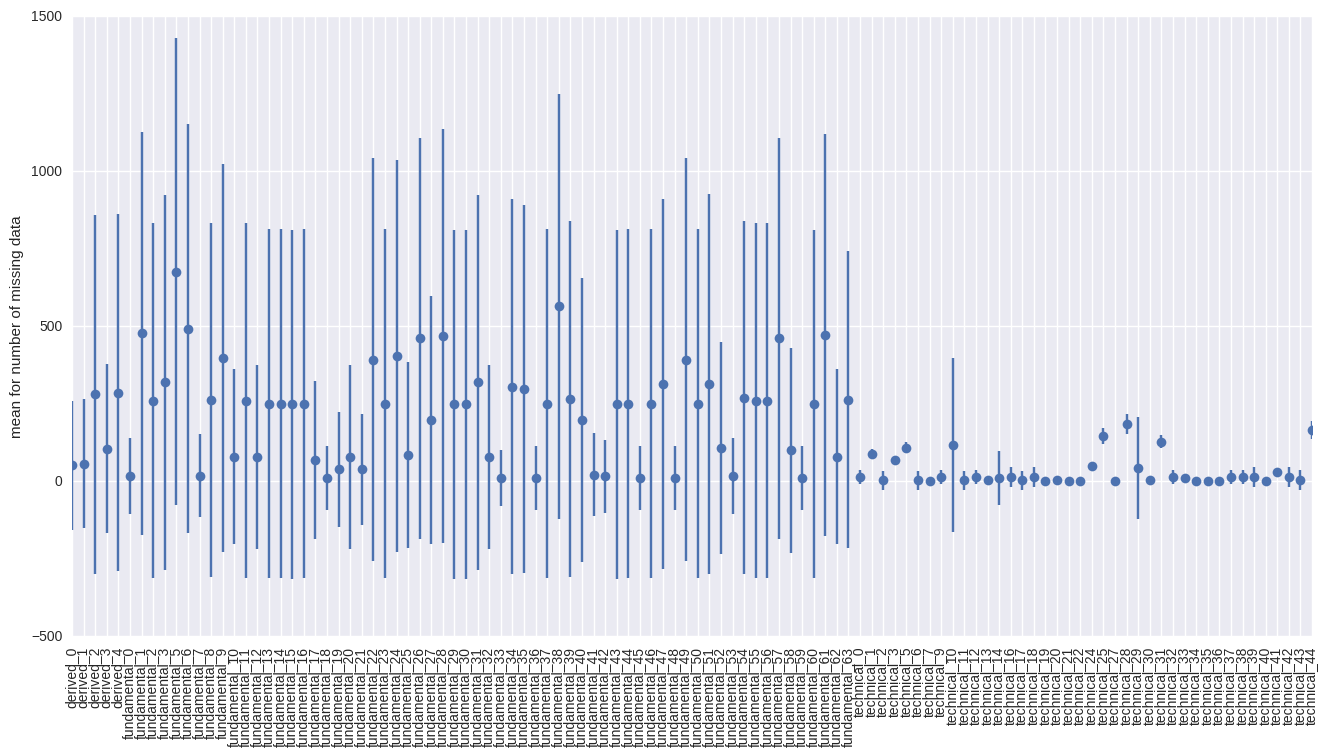

In [10]:
counts = nan_df.xs('count',level='stat',axis=1)
count_mean = counts.mean()
count_std = counts.std()
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(count_mean)),count_mean.index,rotation='vertical')
plt.errorbar(np.arange(len(count_mean)),count_mean,yerr=count_std,fmt='o')
plt.ylabel('mean for number of missing data')

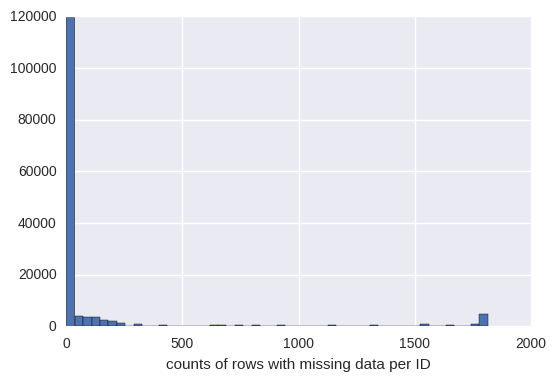

In [11]:
plt.hist(counts.values.flatten(),bins=50)
plt.xlabel('counts of rows with missing data per ID');

Nope, the picture remains the same. My conclusion from this is that there are different classes of IDs which have a different availability of fundamental and derived data. Before pursuing this route further, let's also look at the number of connected time spans for missing data.

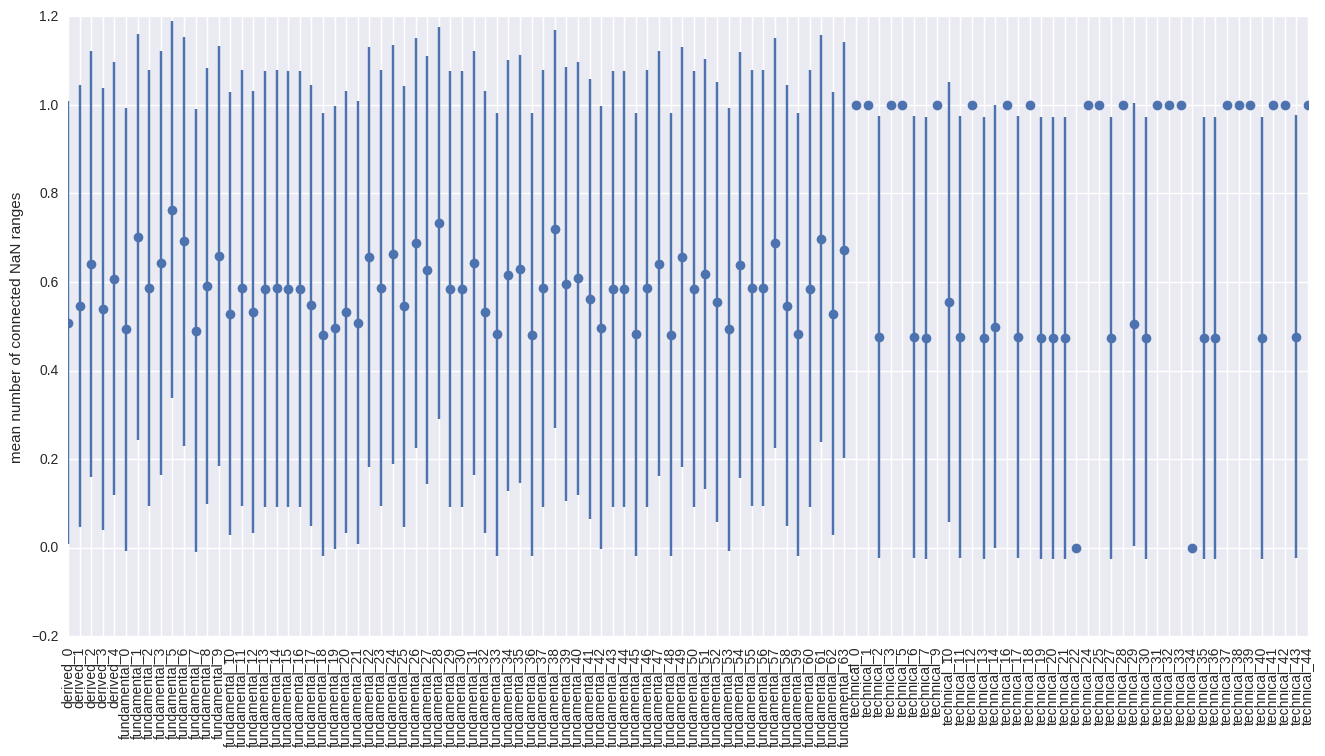

In [12]:
nseq = nan_df.xs('seq',level='stat',axis=1)
nseq_mean = nseq.mean()
nseq_std = nseq.std()
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(nseq_mean)),nseq_mean.index,rotation='vertical')
plt.errorbar(np.arange(len(nseq_mean)),nseq_mean,yerr=nseq_std,fmt='o')
plt.ylabel('mean number of connected NaN ranges')

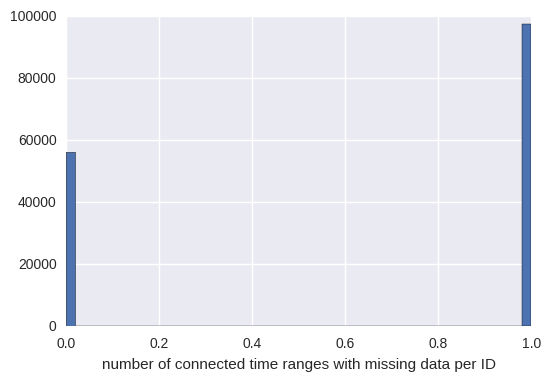

In [13]:
plt.hist(nseq.values.flatten(),bins=50)
plt.xlabel('number of connected time ranges with missing data per ID');

This is very interesting. This means that rows with missing data for a given ID and feature are always continuous in time. It is **not** the case that data for an asset is unavailable, becomes available and then becomes unavailable again. I bet that if data is unavailable, it is at the beginning of the time interval in which the corresponding asset is traded. Let's try to visualize this.

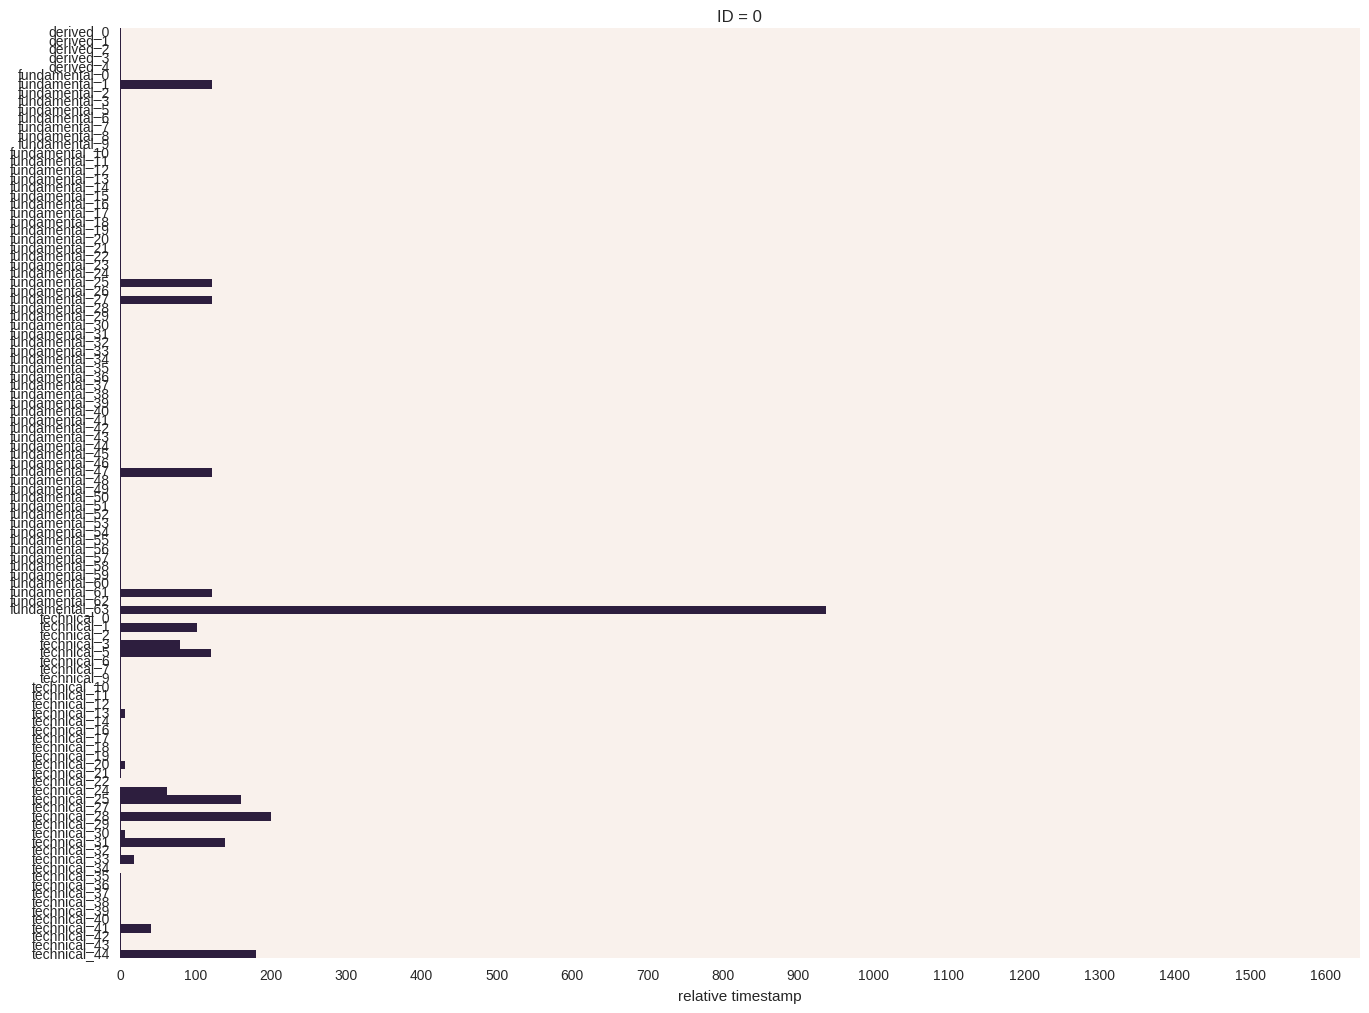

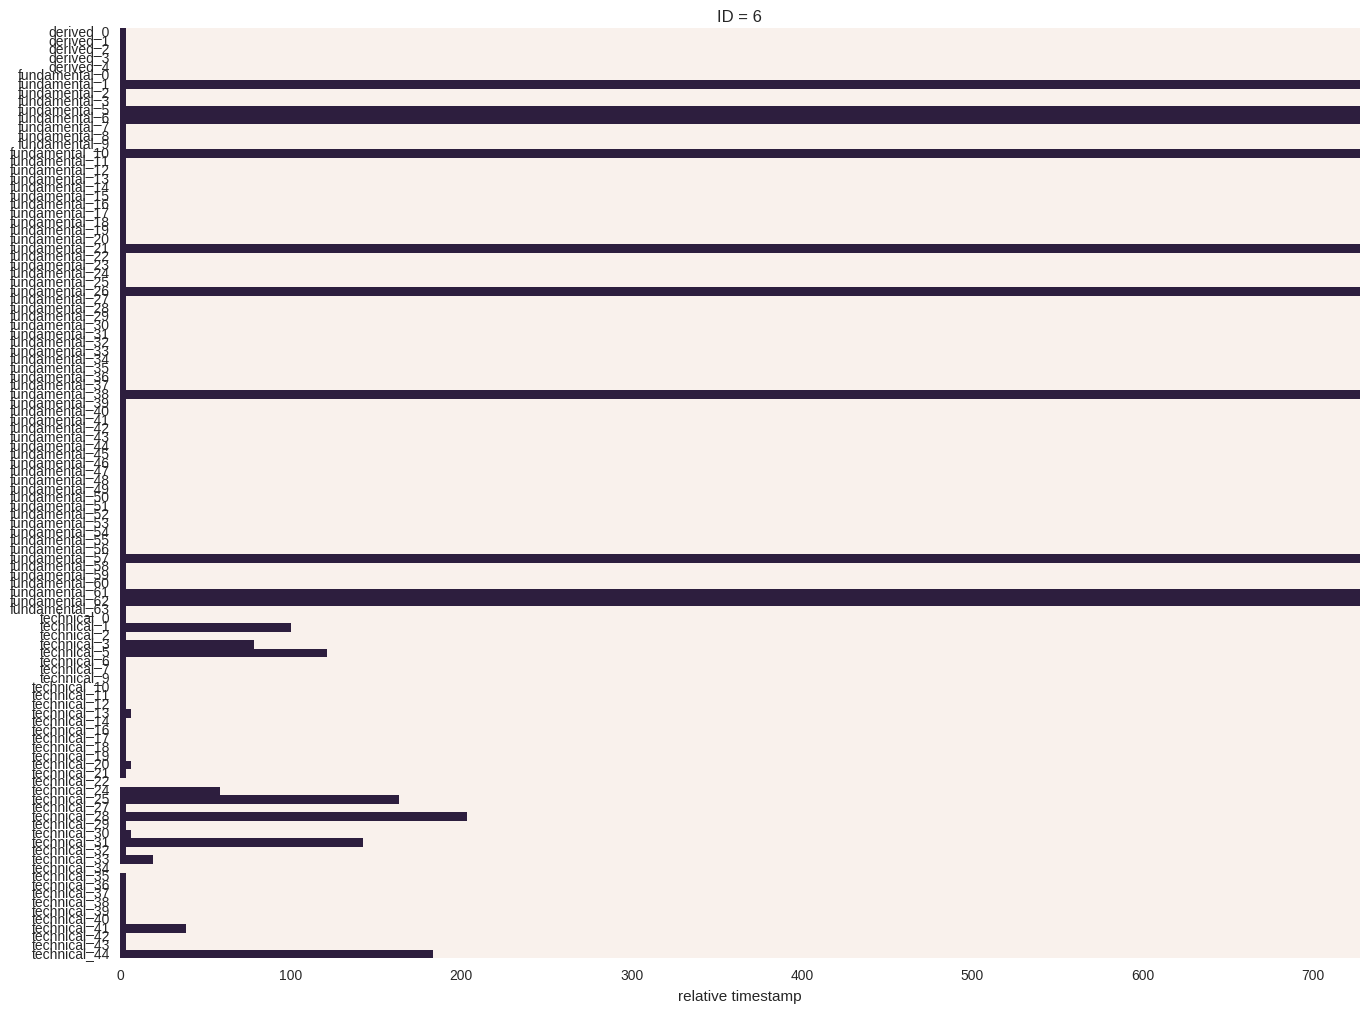

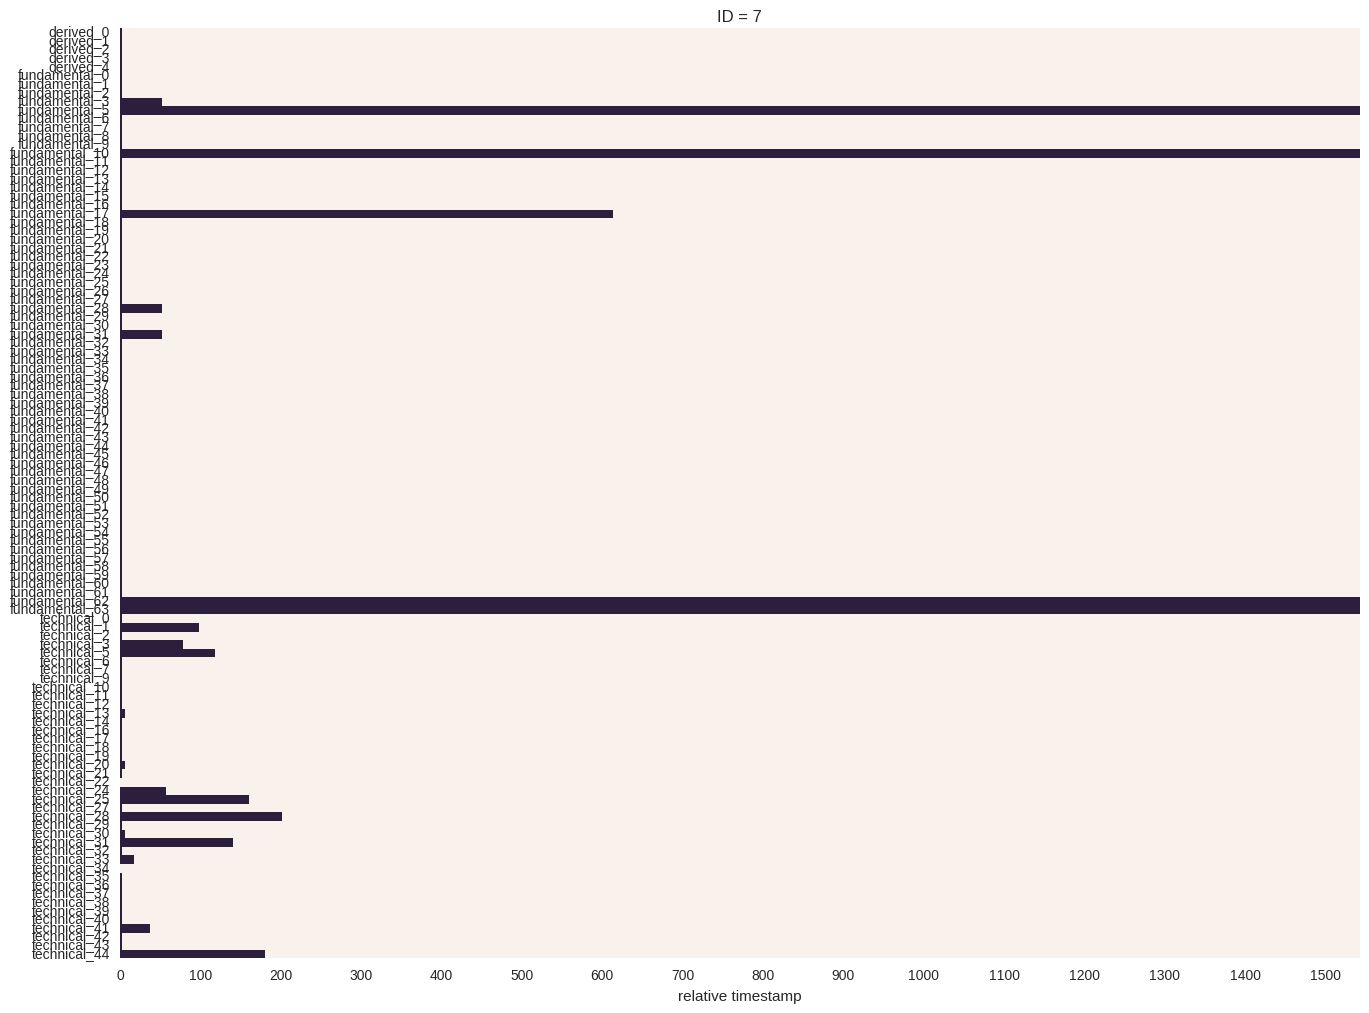

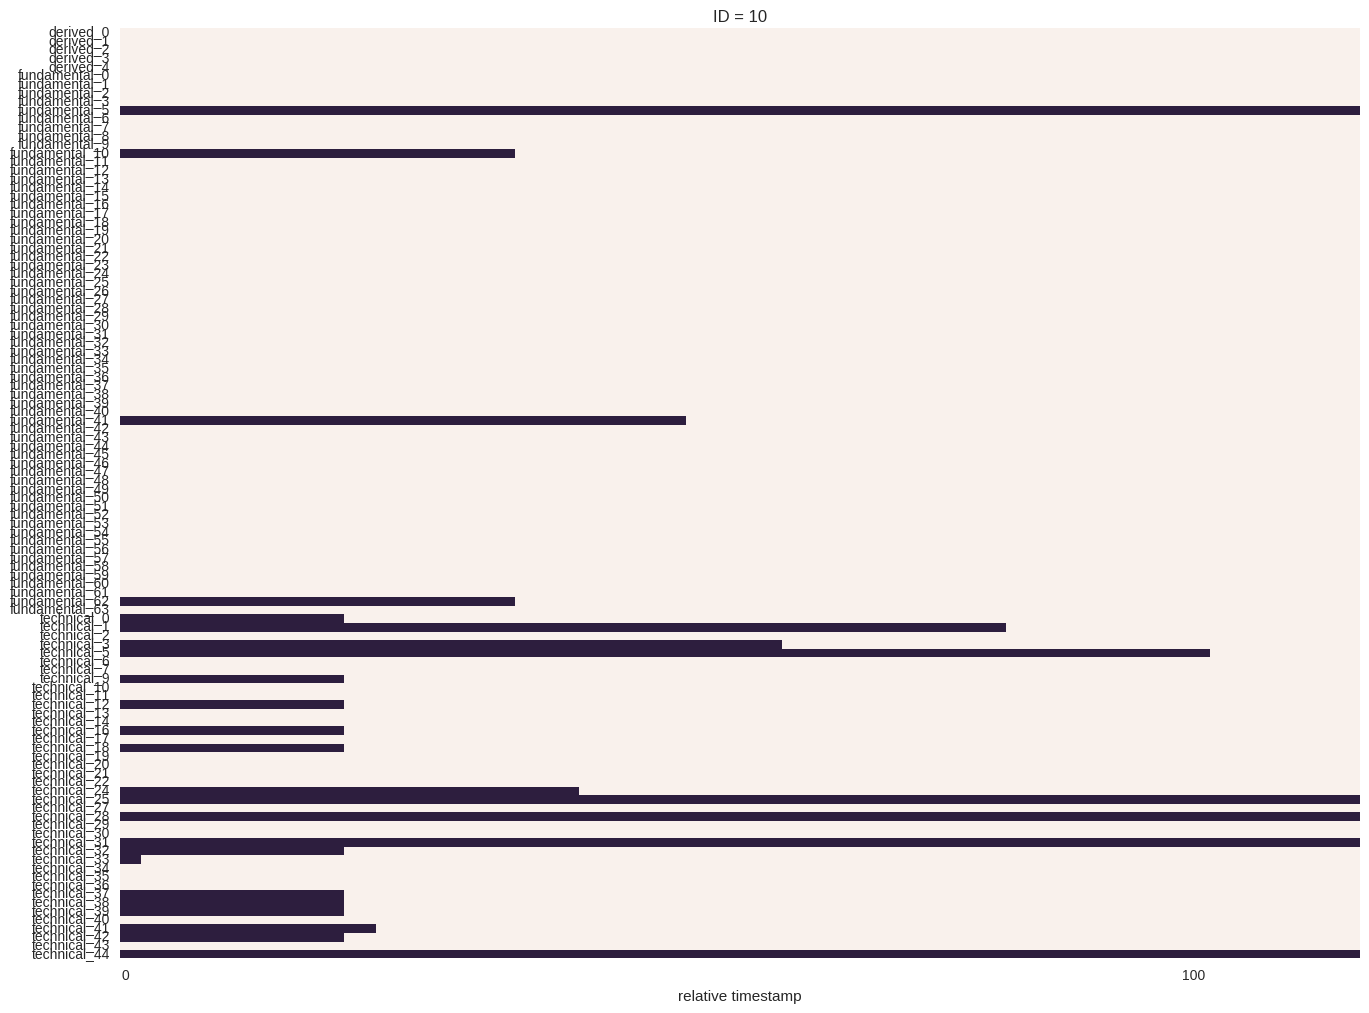

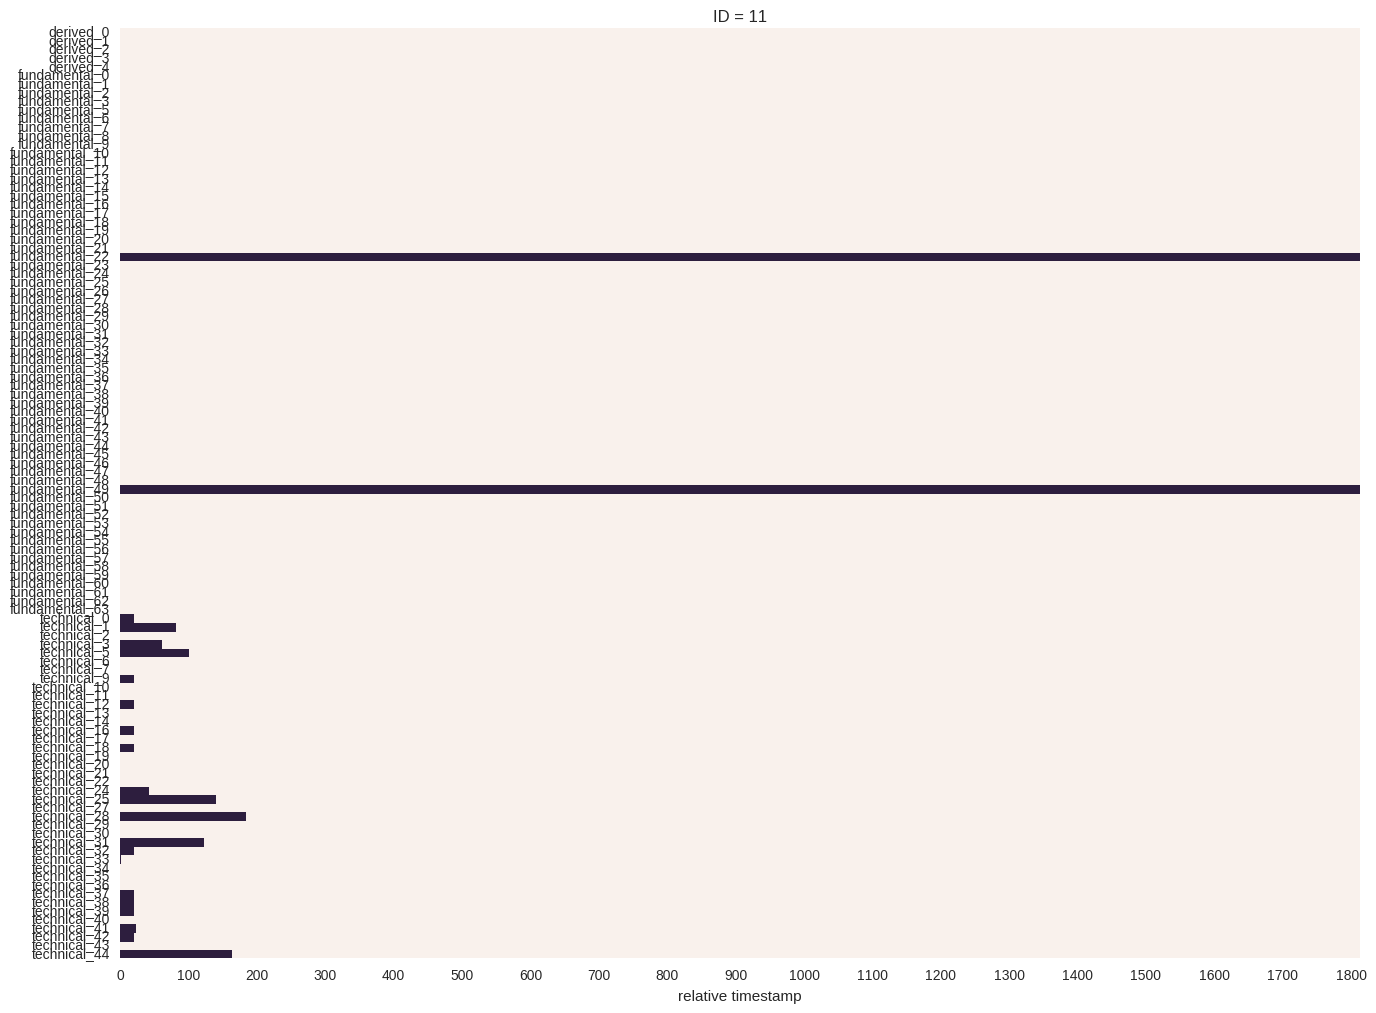

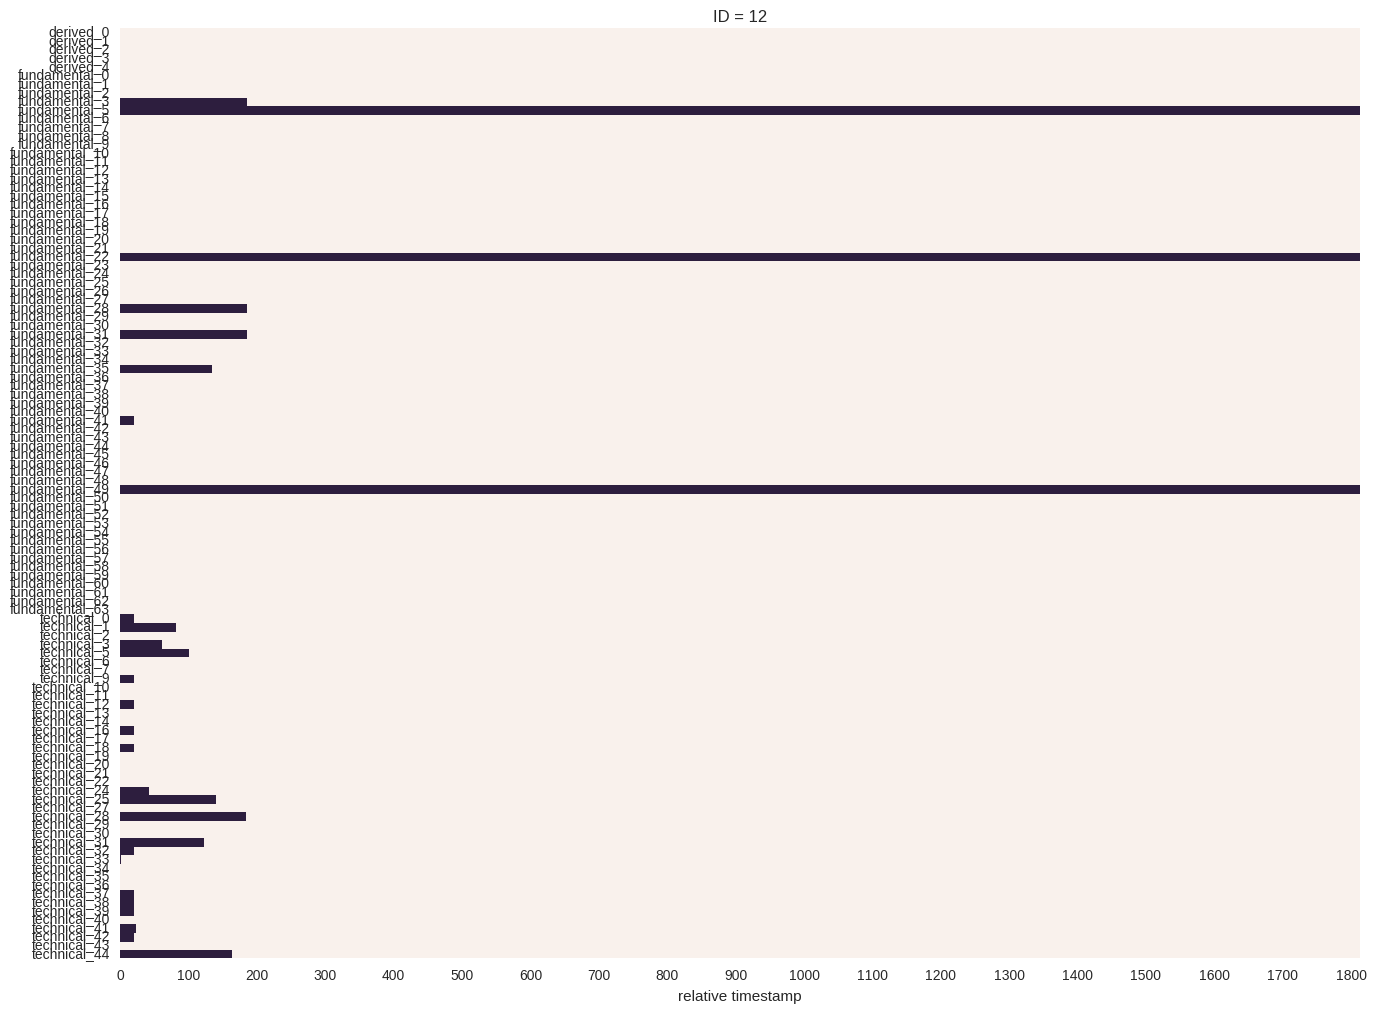

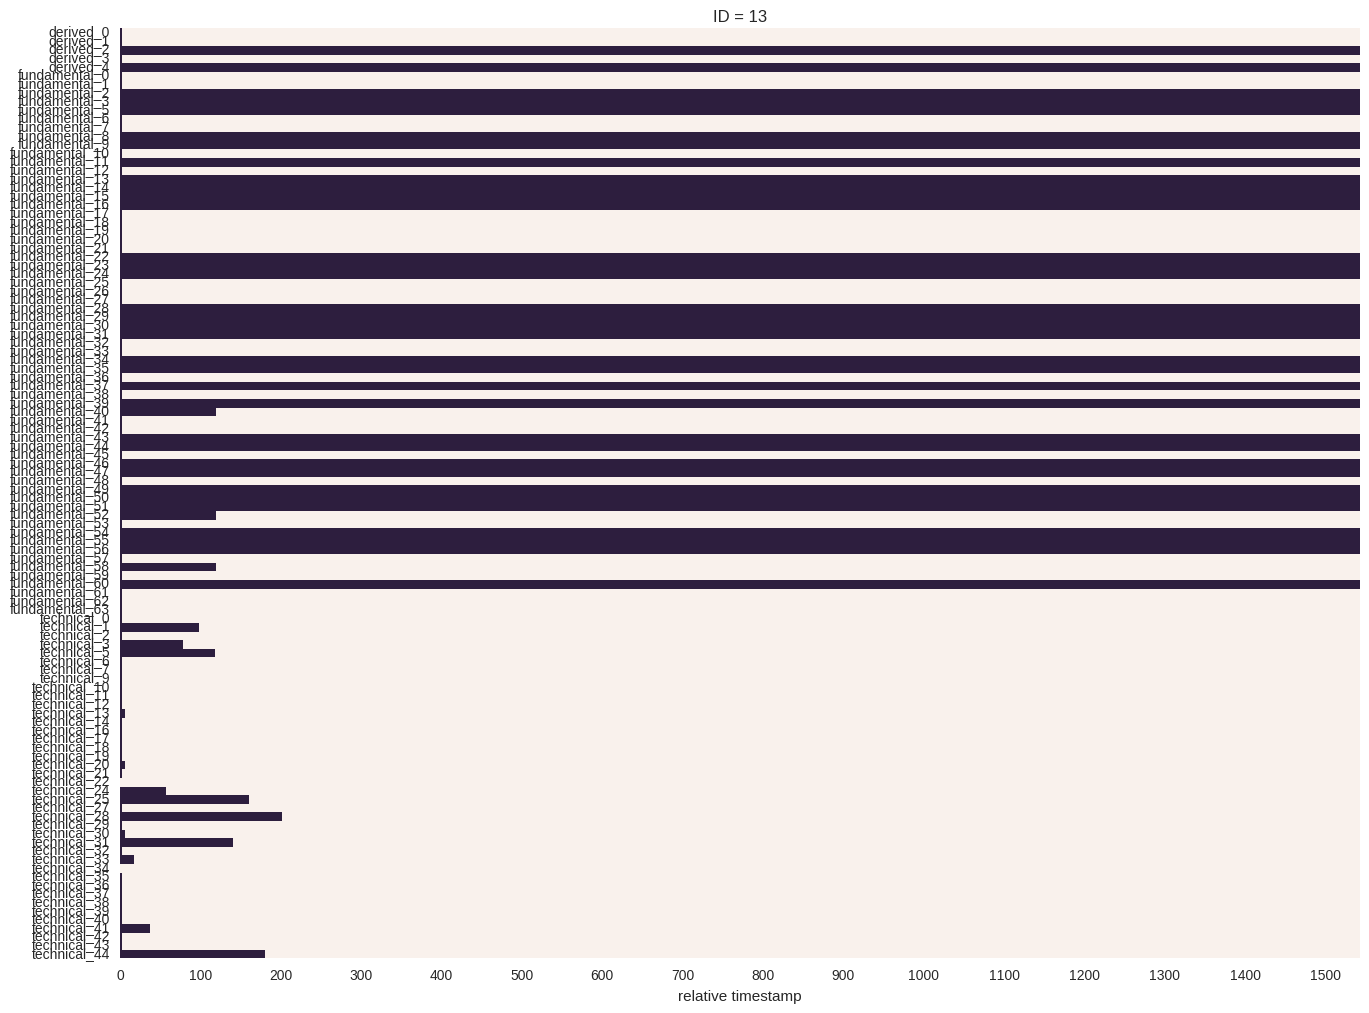

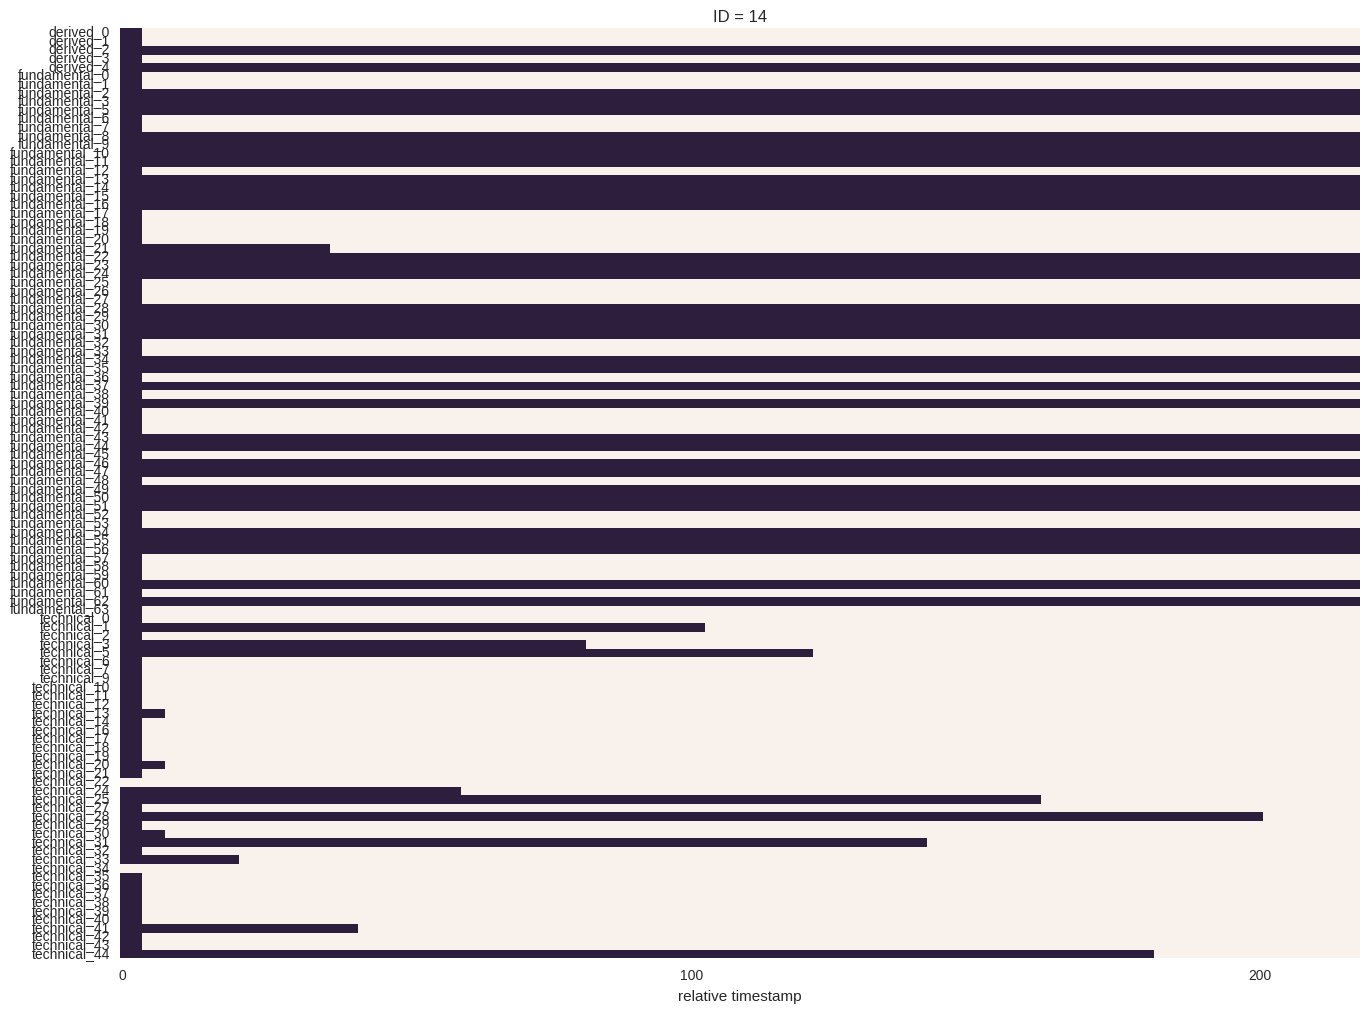

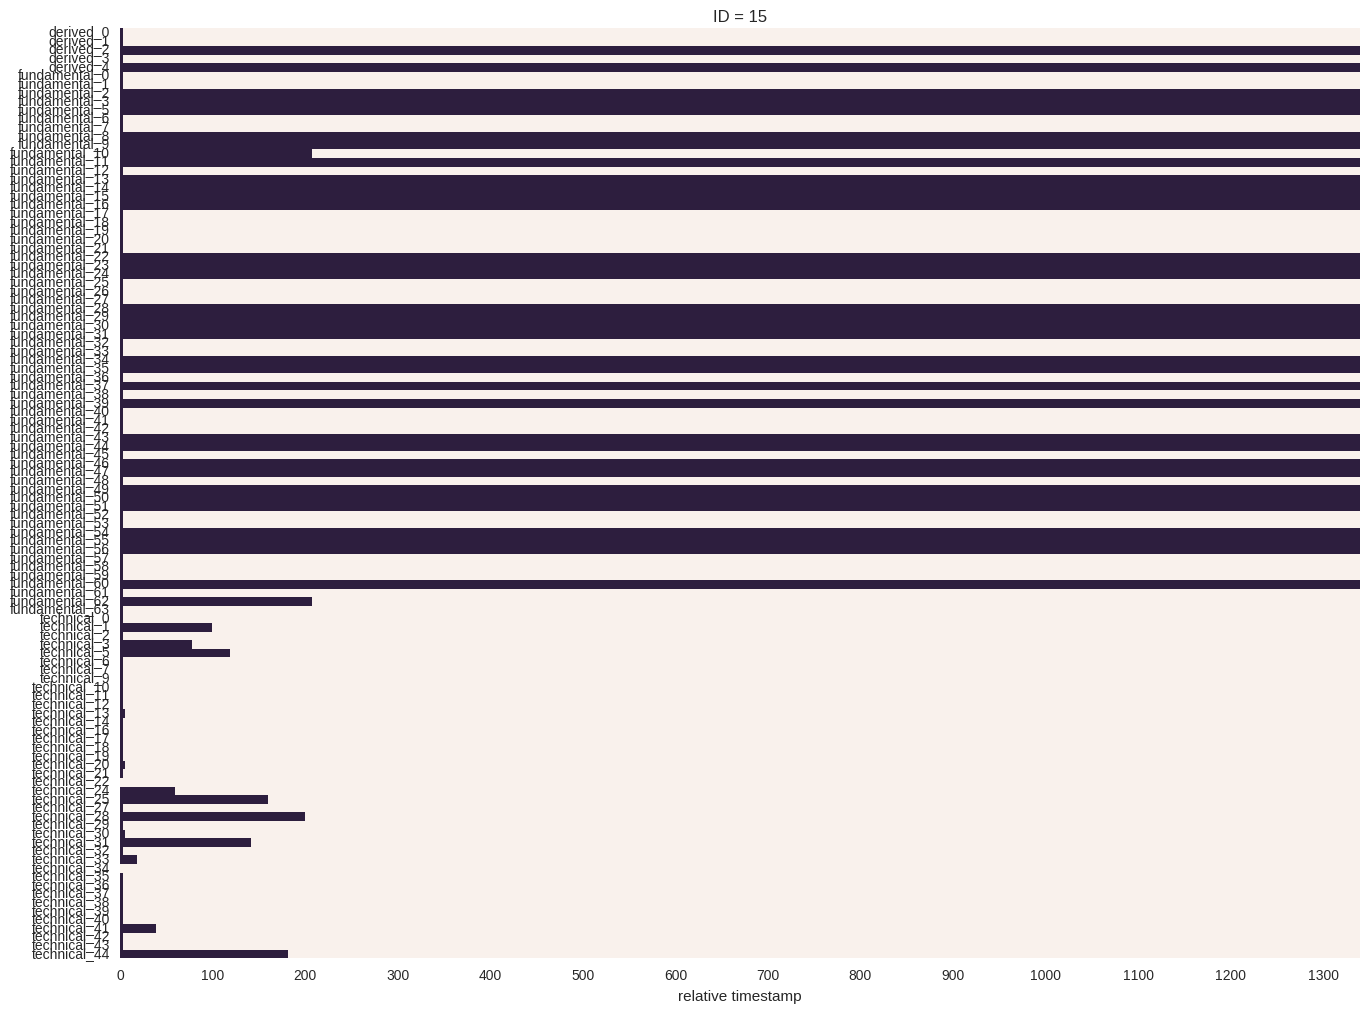

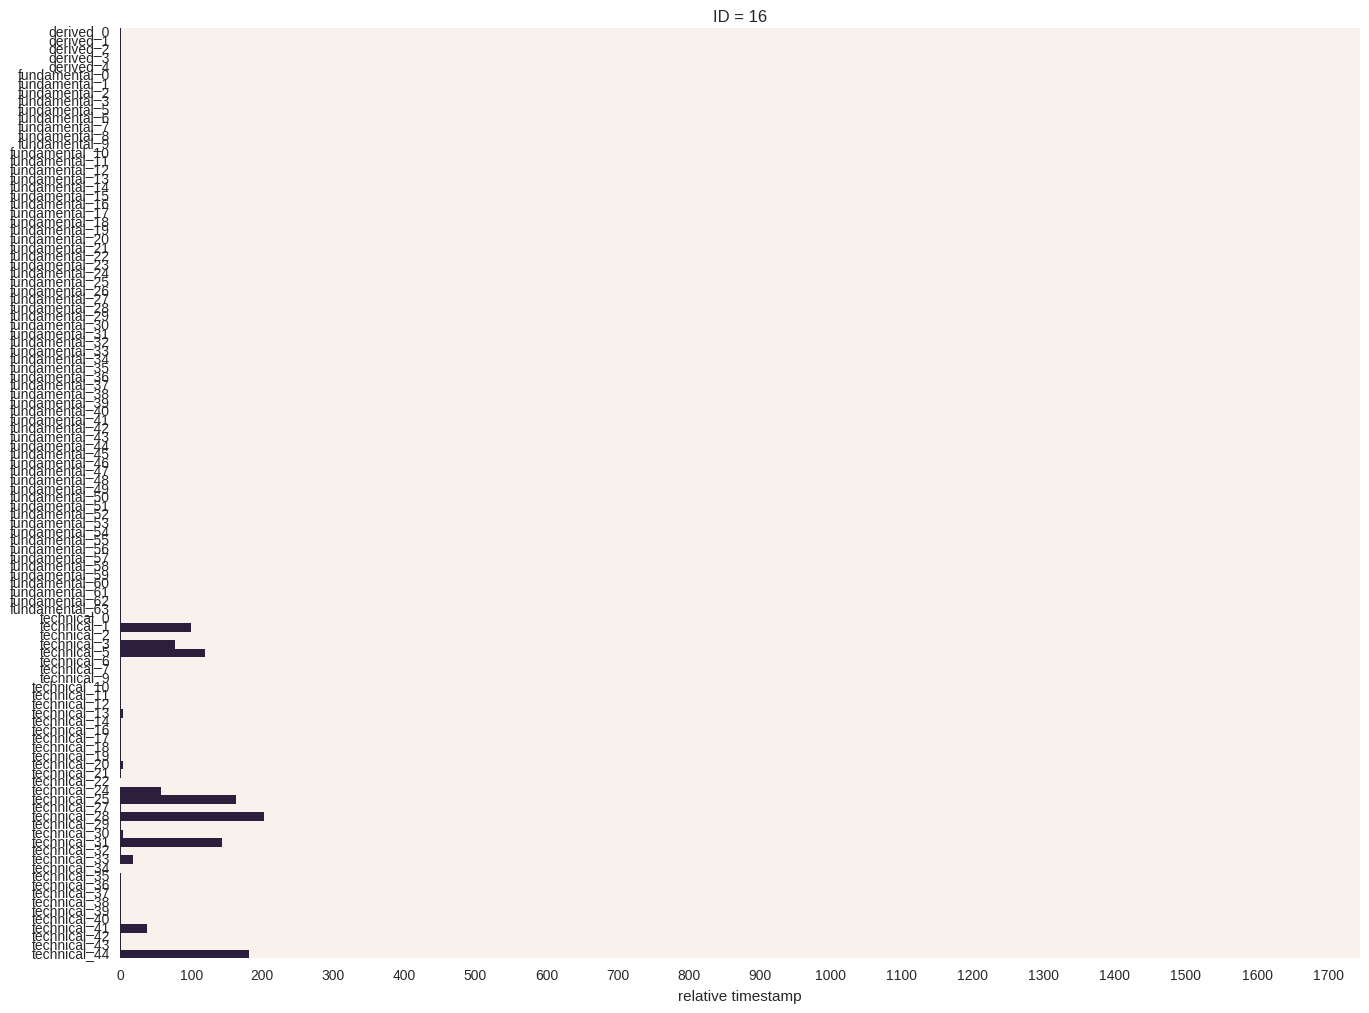

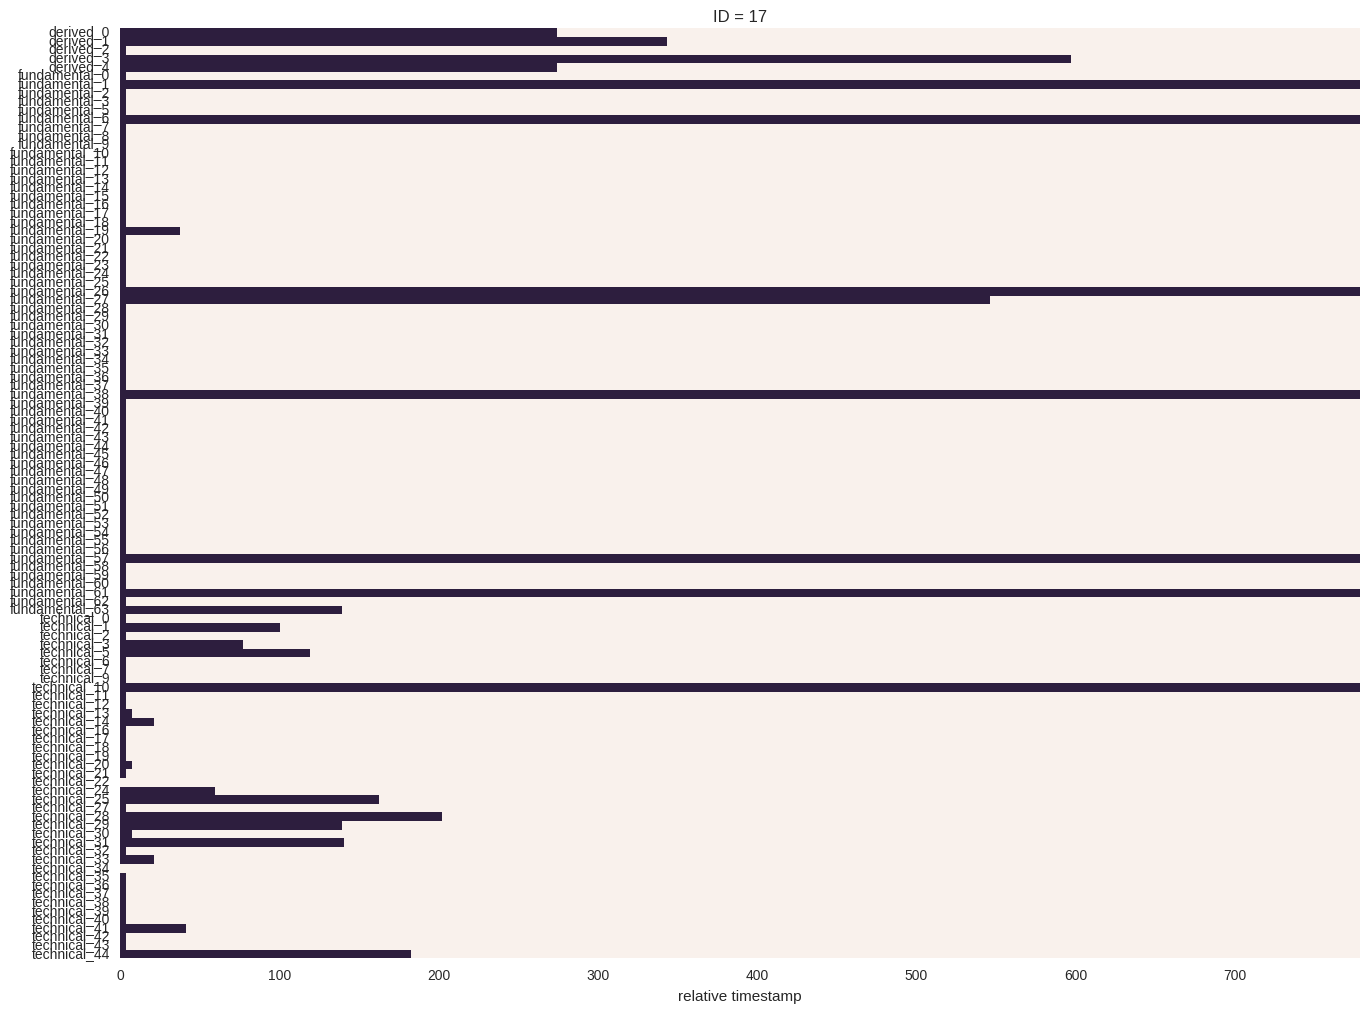

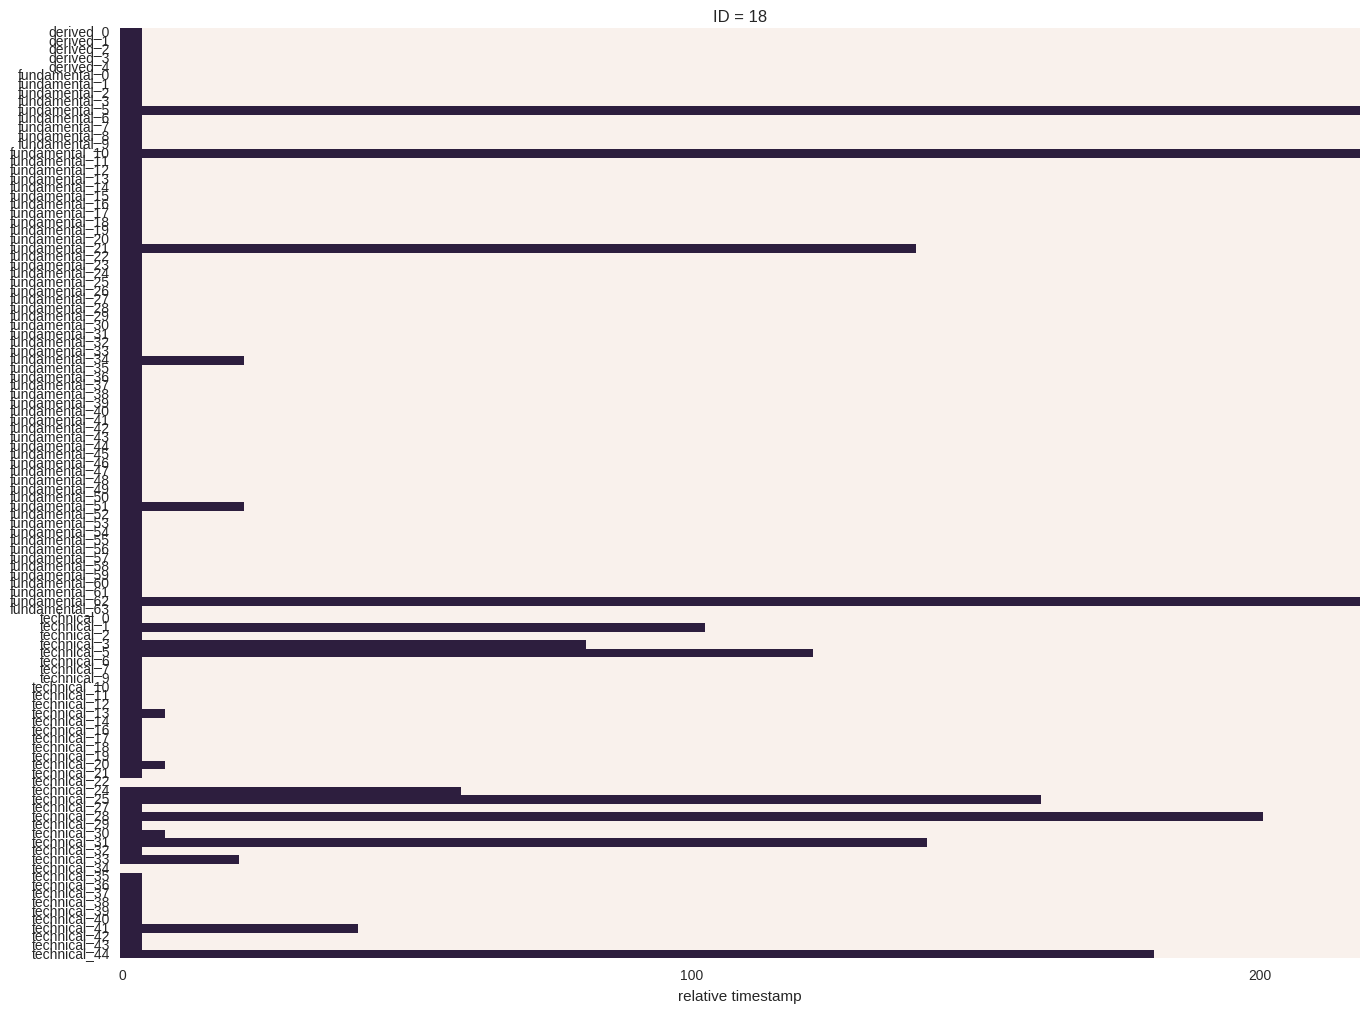

In [14]:
# iterate over IDs
grouped = df.groupby('id');
for i,(n,g) in enumerate(grouped):
    # get missing data flag for feature columns
    d = g.isnull().drop(['timestamp','id','y'],axis=1)
    # normalise time stamp to start with 0 when ID appears for the first time in portfolio
    d.index = g.timestamp - g.timestamp.min()
    d.index.name = 'relative timestamp'
    plt.figure(figsize=(16,12))
    plt.title("ID = %d" % n)
    sns.heatmap(d.T,xticklabels=100,cbar=False)
    # only plot first 10 IDs
    if i > 10:
        break

Bingo! Black bars denote columns and time stamps with missing data. All bars start at the very left which is the time an ID appears for the first time in the portfolio. It also looks like there are different *kinds* of these _barcode plots_. Maybe one can try to categorise IDs based on their missing value patterns... I will post an update on this.